# Introduction

In this notebook you will be creating your own Kmeans algorithm (and comparing to the sci-kit Kmeans algorithm) and extracting different features from the same dataset used in the tutorial. As usual, we begin by importing anything we are going to need.

In [ ]:
# Basic operating system (os), numerical, and plotting functionality
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# scipy statistics functions
from scipy.stats import mode
from scipy.stats import moment

# scikit-learn data utilities
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

!pip install scikit-image

# Color transformations
from skimage.color import rgb2lab

# Feature extractors and classification algorithm
from skimage.feature import greycomatrix, greycoprops
from skimage.feature import local_binary_pattern
from sklearn.cluster import KMeans

# scikit-learn performance metric utilities
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import completeness_score

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
# Set plotting preferences
import matplotlib
%matplotlib inline
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

# Write Your Own Kmeans Algorithm

You can learn more about Kmeans here: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html 


## Building Your kmeans Function
In the following code cells, you will flesh out the necessary components of the Kmeans algorithm. Look for the marker to `-999` indicate lines that need to be completed.

In [ ]:
def get_distances(data, cluster_centers):
    """Computes the distance between each data point an a cluster center"""
    # Count the number of data points and number  of clusters expected
    num_dim, num_points = data.shape
    _, num_clusters = cluster_centers.shape

    # Initialize an array to store distances between clusters centers and points
    distances = np.zeros((num_clusters, num_points))

    # Loop over each cluster and perform distance calculations
    for iclust in range(num_clusters):
        # Grab and reshape the cluster center at this index
        this_center = cluster_centers[:, iclust].reshape((num_dim, 1))

        # Compute the positional difference between data and cluster center
        data_offset = data - this_center # <-- Modify this line to get the positional offset

        # Use the Euclidean metric to compute the distance
        # distance = sqrt(sum_i { (p_i - p_i_0)**2} ) <-- where `p_i` indicates
        #                                                 the position along the
        #                                                 `i-th` dimension.
        data_offset_sq = data_offset**2 # <-- Compute the offset squared on this line
        print(data_offset_sq.shape)
        #print(data_offset_sq)
        # We are going to accelerate the summation process by using the `axis=0`
        # keyword argument of the `np.sum` function. This causes the `np.sums
        # function to add all the elements along the first (0-th) axis. This is
        # the axis that indexes the (x, y, z, etc...) of our data. Thus, in the
        # two dimensional case, this is equivalent to the familiar
        #
        # sqrt((x - x0)**2 + (y - y0)**2) <-- Pythagorean theorem
        #
        # In three dimensions it is
        #
        # sqrt((x - x0)**2 + (y - y0)**2 + (z - z0)**2)
        #
        # and so on... Using the `axis` keyword, we can allow `data` to
        # represent positions in *any* number of dimensions. You can learn more
        # here: https://numpy.org/doc/stable/reference/generated/numpy.sum.html
        this_distances = np.sqrt(np.sum(data_offset_sq, axis=0))
        print(this_distances.shape)
        #print(this_distances)
        # Store the computed distances in the output array
        distances[iclust] = this_distances
        print(distances.shape)

    return distances

In [ ]:
def get_new_cluster_centers(data, cluster_indices):
    """Computes cluster center using the indices assigned to each data point"""
    # Count the number of clusters to be assigned
    num_dim, num_points = data.shape
    num_clusters = np.unique(cluster_indices).size

    # Initialize an array to store the cluster centers
    cluster_centers = np.zeros((num_dim, num_clusters))

    # Loop over each cluster and locate which data points 
    for iclust in range(num_clusters):
        # We can use the `np.where` function to grab the indices at which
        # the values of `nearest_cluster_ind` is equal to cluster index `iclust`
        this_cluster_mask = (cluster_indices==iclust) # <-- Locate where the cluster index is equal to this cluster index
        this_cluster_inds = np.where(this_cluster_mask)[0]

        # Compute the mean position of the data points at the indices now stored
        # in the `this_cluster_inds` variable. Try using that `axis` keyword!
        this_center = np.mean(data[:,this_cluster_inds], axis=1) # <-- Compute the mean position
        
        # Store this cluster center in the output array
        cluster_centers[:, iclust] = this_center

    return cluster_centers

In [ ]:
def my_kmeans_function(data, num_clusters, num_iterations):
    """
    Applies the Kmeans clustering algorithm to the `data`

    Arguments
    ---------
    data : ndarray, shape (num_dim, num_points)
        All of the data to be clustered.

    num_clusters : int
        The number of clusters to use in the clustering process

    num_iterations : int
        The number of times to loop over the clustering process
    """
    # Get number of dimensions for data
    num_dim, num_points = data.shape

    # We can use some randomly selected data points as starting guesses for
    # the cluster centers. These are guaranteed to be within the data range!
    random_data_inds = np.random.choice(num_points, num_clusters, replace=False)
    cluster_centers = data[:, random_data_inds]
    print(cluster_centers)

    # # Generate some random cluster center starting points. We are using that
    # # nifty `axis` keyword described in the functions above.
    # dmin = data.min(axis=1).reshape((num_dim, 1))   # Data min along each dim.
    # dmax = data.max(axis=1).reshape((num_dim, 1))   # Data max along each dim.
    # drange = (dmax - dmin)                          # Data range along each dim.

    # # Generate some random starting points, then scale and re-center them
    # cluster_centers = np.random.random(size=(num_dim, num_clusters))
    # cluster_centers = drange*cluster_centers + dmin

    # Perform the requested number of iterations
    for iiter in range(num_iterations):
        # Compute the distance betwen each data-point and cluster-center
        distances = get_distances(data, cluster_centers) # <-- use one of your functions from above

        # Grab the cluster index for which the euclidian distance is smallest
        # In case you did not know about the `argmin` method, it is pretty neat:
        # https://numpy.org/doc/stable/reference/generated/numpy.argmin.html
        nearest_cluster_ind = distances.argmin(axis=0)

        # Compute new cluster cunters based on nearest cluster indexing
        cluster_centers = get_new_cluster_centers(data, nearest_cluster_ind) # <-- use one of your functions from above

    return cluster_centers

## Generate and Visualize Some Clustered Data

Conveniently, scikit-learn provides a function to generate some "blobs" of clustered data for us to test our Kmeans algorithm.

In [ ]:
# Creating and visualizing a random datset using sklearn's make_blobs
data, actual_cluster = make_blobs(n_samples=400, centers=3, cluster_std=0.80,
                                  random_state=0)

# Transpose data to be a bit more consistent with conventions in this notebook
data = data.T
print(data.shape)

(2, 400)


In [ ]:
# Apply the Kmeans algorithm from above
num_clusters = 3
num_iterations = 10
cluster_centers = my_kmeans_function(data, num_clusters, num_iterations)
#print(cluster_centers)

# Estimate which cluster each datapoint belongs to using nearest neighbor from
# estimated cluster centers. We can just repeat some lines from our Kmeans...
distances = get_distances(data, cluster_centers)
nearest_cluster_ind = distances.argmin(axis=0)

# Loop over each cluster and build a dictionary mapping from the cluster index
# in `nearest_cluster_ind` to the actual cluster number used when generating the
# original data.
est_to_true_map = {}
for iclust in range(num_clusters):
    # Grab the *most common* true cluster number associated with this index
    this_cluster_mask = nearest_cluster_ind == iclust
    this_est_to_true = mode(actual_cluster[np.where(this_cluster_mask)])[0][0]
    est_to_true_map[iclust] = this_est_to_true

# Now, apply this mapping to the data in `nearest_cluster_ind`
# Here, we are using a technique called "list comprehension." It is *also*
# pretty nifty and worth knowing about. You can read more here:
# https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions
estimated_cluster = np.array([est_to_true_map[i] for i in nearest_cluster_ind])

# Compute a classification accuracy
accuracy = accuracy_score(actual_cluster, estimated_cluster)
print(accuracy)

[[1.5080588  1.03151618 1.74736367]
 [2.2253043  0.4293187  0.97314493]]
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
(2, 400)
(400,)
(3, 400)
0.9825


Let's visualize the results of this Kmeans clustering attempt.

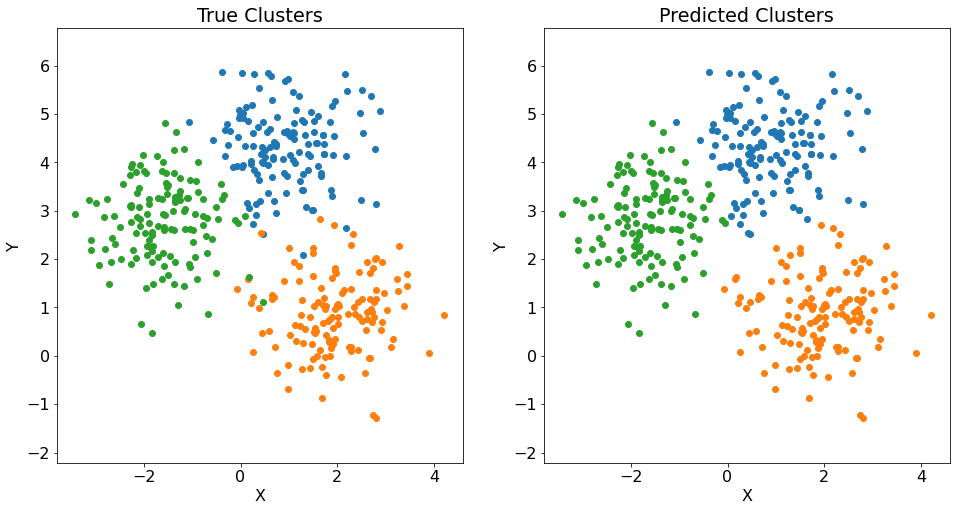

In [ ]:
# Visualize that data
fig, ax_arr = plt.subplots(1, 2, figsize=(16, 8))

# Loop over each cluster and plot its data (with aunique color!)
for iax in range(2):
    for iclust in np.unique(actual_cluster):
        if iax == 0:
            cluster_data = data[:, np.where(actual_cluster == iclust)]
        elif iax == 1:
            cluster_data = data[:, np.where(estimated_cluster == iclust)]

        # Actually plat the clusters
        ax_arr[iax].scatter(*cluster_data)

    # Add some annotation and formatting
    ax_arr[iax].axis('equal')
    ax_arr[iax].set_title(['True Clusters', 'Predicted Clusters'][iax])
    ax_arr[iax].set_xlabel('X')
    ax_arr[iax].set_ylabel('Y')

plt.show()

This Kmeans example was initialized using some blobs with a small amount of overlap. What happens if you adjust the parameters of the cluster-generating code.

* Broader clusters `cluster_std`: determines how spread out the clusters are
* More data points `n_samples`: changes number of samples
* Number of blobs `centers`: determines number of clusters/centers

(**YOUR ANSWER ABOVE**)

# More Feature Extraction

As we saw in the last section of the tutorial notebook, it is possible to extract a set of descriptive features from an image (much like was done with 1D signals in the previous week). In the following section, we will work through several examples of feature extraction and image classification with Kmeans using those extracted features.

## Histogram Features

There are several histogram features that can be applied in the context of image processing. 

One featue is the mean, or intensity value of all of the pixels in the image. This can be thought of as the average brightness of the entire image.

Another feature is the variance, which explains how close pixel intensity values are to each other. A low variance would explain that most of the pixel values are extremely close together, while a high variance would indicate that pixel values vary more and are spead around the mean. 

The standard deviation is the the variance squared.

You can read more about histogram features in the context of pictures here: http://www.giassa.net/?page_id=470

In [ ]:
# Define the current directory and the directory where the files to download can
# be found
current_dir = '/'
remote_path = 'https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/NotebookExampleData/Week3/data_nuclei/crc/'

data_dir = '/crc_data'
if not os.path.isdir(data_dir):
  os.mkdir(data_dir)

os.chdir(data_dir)
for ii in range(1, 6):
    basename = f'rgb0{ii}.npz'
    filename = os.path.join(remote_path, basename)

    if not os.path.isfile(basename):
      cmd = f'wget {filename}'
      print(cmd)
      os.system(cmd)

os.chdir(current_dir)

wget https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/NotebookExampleData/Week3/data_nuclei/crc/rgb01.npz
wget https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/NotebookExampleData/Week3/data_nuclei/crc/rgb02.npz
wget https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/NotebookExampleData/Week3/data_nuclei/crc/rgb03.npz
wget https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/NotebookExampleData/Week3/data_nuclei/crc/rgb04.npz
wget https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/NotebookExampleData/Week3/data_nuclei/crc/rgb05.npz


In [ ]:
# Define a function to load the data from the assumed download path
def load_images(colorspace='rgb'):
    colorspace_lower = colorspace.lower()
    if colorspace_lower not in ['rgb', 'gray', 'grey', 'lab']:
        raise ValueError(f'`colorspace` value of {colorspace} not recognized')

    filename = os.path.join(data_dir, 'rgb01.npz')
    print(f'loading {filename}')
    tmp = np.load(os.path.join(data_dir, 'rgb01.npz'), allow_pickle=True)

    images = tmp['rgb_data']
    if colorspace_lower == 'rgb':
        pass
    elif colorspace_lower in ['gray', 'grey']:
        images = np.mean(images, axis=-1)
    elif colorspace_lower == 'lab':
        images = rgb2lab(images)

    labels = tmp['labels']
    
    label_to_str = tmp['label_str']
    label_to_str = label_to_str.tolist() # Convert label_to_str into a dict

    print('Loaded images with shape {}'.format(images.shape))
    del tmp

    for ii in range(2,6):
        filename = os.path.join(data_dir, f'rgb0{ii}.npz')
        print(f'loading {filename}')
        tmp = np.load(filename, allow_pickle=True)

        these_images = tmp['rgb_data']
        if colorspace_lower == 'rgb':
            pass
        elif (colorspace_lower == 'gray') or (colorspace_lower == 'grey'):
            these_images = np.mean(these_images, axis=-1)
        elif colorspace_lower == 'lab':
            these_images = rgb2lab(these_images)

        images = np.append(images, these_images, axis=0)
        labels = np.append(labels, tmp['labels'], axis=0)

        print('Loaded images with shape {}'.format(these_images.shape))
        del tmp

    images = images.astype(np.float)
    print('Final image data shape: {}'.format(images.shape))
    print('Number of image labels: {}'.format(*labels.shape))

    return images, labels

In [ ]:
# Load in the images and convert them to L*a*b* (see function from tutorial)
images_color, labels = load_images(colorspace='rgb') # <-- Come back and try in RGB colorspace
num_images, num_y, num_x, num_ch = images_color.shape

loading /crc_data/rgb01.npz
Loaded images with shape (1000, 150, 150, 3)
loading /crc_data/rgb02.npz
Loaded images with shape (1000, 150, 150, 3)
loading /crc_data/rgb03.npz
Loaded images with shape (1000, 150, 150, 3)
loading /crc_data/rgb04.npz
Loaded images with shape (1000, 150, 150, 3)
loading /crc_data/rgb05.npz
Loaded images with shape (1000, 150, 150, 3)
<ipython-input-10-cf8a35a87722>:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  images = images.astype(np.float)
Final image data shape: (5000, 150, 150, 3)
Number of image labels: 5000


In [ ]:
# Initialize an array to store the features
num_features = 3*num_ch     # We are computing three features per channel
hist_features = np.zeros((num_images, num_features))

# Compute histogram features
for i_img in range(num_images):

    # Compute the mean of each of the image color channels. You are going to
    # need to grab the current image (using `i_img`), then grab all of the
    # rows and columns (using the `:` slicing operator), and grab one of
    # the three color channels on which to compute the mean value.
    #
    # You can use `np.mean` on the flattened channel data for this image
    hist_features[i_img, 0] = np.mean(images_color[i_img, :, :, 0]) # <-- populate with proper argument
    hist_features[i_img, 1] = np.mean(images_color[i_img, :, :, 1]) # <-- populate with proper argument
    hist_features[i_img, 2] = np.mean(images_color[i_img, :, :, 2]) # <-- populate with proper argument

    # Compute the standard deviation of each of the image color channels
    # You can use `np.std` on the same, flattened channel data for this image
    hist_features[i_img, 3] = np.std(images_color[i_img, :, :, 0]) # <-- populate with proper function *and* argument
    hist_features[i_img, 4] = np.std(images_color[i_img, :, :, 1]) # <-- populate with proper function *and* argument
    hist_features[i_img, 5] = np.std(images_color[i_img, :, :, 2]) # <-- populate with proper function *and* argument

    # Compute the "second moment" (variance) of each of the image color channels
    # You can use `np.var` on the same, flattened channel data for this image
    hist_features[i_img, 6] = np.var(images_color[i_img, :, :, 0]) # <-- populate with proper function *and* argument
    hist_features[i_img, 7] = np.var(images_color[i_img, :, :, 1]) # <-- populate with proper function *and* argument
    hist_features[i_img, 8] = np.var(images_color[i_img, :, :, 2]) # <-- populate with proper function *and* argument


In [ ]:
# Apply a train_test_split here
X_train, X_test, y_train, y_test = train_test_split(hist_features, labels, test_size=0.25)

In [ ]:
# Apply the (*much faster*) scikit-learn Kmeans algorithm to get the image
# data clustering (You can experiment with different K-means algorithms (auto,
# full, or elkan)). You can learn more about these here:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

# Cluster the images using the KMeans algorithm
kmeans_object = KMeans(algorithm='elkan', n_clusters=8, max_iter=1)
kmeans_estimator = kmeans_object.fit(X_train) 

In [ ]:
# Predict using Kmeans estimator
preds = kmeans_estimator.predict(X_test)

Now that we have actually made our predictions for which cluster each of the test images belongs to, we need to convert cluster numbers into classification label numbers. To do that, we will examine the most *common* label within each cluster and assume that is the correct label to associate with the cluster.

In [ ]:
# Initialize an array to store the classification prediction labels
pred_labels = np.zeros_like(preds)

# Loop over each cluster
for icluster in range(8):
    # Build a mask indicating where the cluster number is equal to `icluster`
    mask = (preds == icluster)

    # Handle the cases where this cluster was never predicted for test data
    if np.sum(mask) == 0:
        print(f'Cluster {icluster} is not populated by test data')
        continue

    # Assign the *most common* label to *this*
    this_label = mode(y_test[mask]).mode[0]
    pred_labels[mask] = this_label

    # Printe the association being made for some transparency to the user
    print(f'Cluster {icluster} gets label {this_label}')
    

Cluster 0 gets label 2
Cluster 1 gets label 5
Cluster 2 gets label 4
Cluster 3 gets label 3
Cluster 4 gets label 6
Cluster 5 gets label 1
Cluster 6 gets label 7
Cluster 7 gets label 1


In [ ]:
# Compute the accuracy
acc_hist = accuracy_score(y_test, pred_labels)
print(acc_hist)

0.4024


Another metric worth considering is the "completeness score." This is a measure of how frequently the images of a single class were assigned to *multiple* clusters. You can read more about this metric at the scikit-learn page for [completeness score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html).

In [ ]:
# Compute the completeness score
comp_hist = completeness_score(y_test, pred_labels)
print(comp_hist)

0.36727257189906193


If you're getting tired of waiting for KMeans to run, you can use the MiniBatchKMeans function to perform KMeans using batched sub-sets of the training data. This will run significantly faster at the cost of some accuracy. You will also need to go back and change all of the `KMeans()` calls to `MiniBatchKMeans()`.

In [ ]:
 # A faster, potentially less accurate Kmeans
 from sklearn.cluster import MiniBatchKMeans

### Repeat in RGB
These histogram features can also be computed using RGB colorspace rather than L* a* b* colorspace. How does that affect the accuracy of the classification?

## Local Binary Patterns

Another feature extraction procedure to consider involves the computation of the "Local Binary Pattern." This procedure computes a local representation of texture by comparing a pixel with its surrounding pixels and converting these neigbor pixel values into binary digits. You can read more about Local Binary Patterns (LBP) here:

https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/

And here:

https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_local_binary_pattern.html


In [ ]:
# Clear out the old data
try:
    del X_train_ab, X_test_ab, y_train, y_test
except:
    pass
try:
    del images_color
except:
    pass

# *** OKAY, YOUR TURN! ***
# Refer to the examples above and in the tutorial to load the RGB images
images_color, labels = load_images(colorspace='rgb') # <-- Use the loading function

# Grab just the red channel since that's where most of the information is
images_red = images_color[:, :, :, 0] # <-- Grab just the *red* channel of these images
del images_color

loading /crc_data/rgb01.npz
Loaded images with shape (1000, 150, 150, 3)
loading /crc_data/rgb02.npz
Loaded images with shape (1000, 150, 150, 3)
loading /crc_data/rgb03.npz
Loaded images with shape (1000, 150, 150, 3)
loading /crc_data/rgb04.npz
Loaded images with shape (1000, 150, 150, 3)
loading /crc_data/rgb05.npz
Loaded images with shape (1000, 150, 150, 3)
<ipython-input-10-cf8a35a87722>:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  images = images.astype(np.float)
Final image data shape: (5000, 150, 150, 3)
Number of image labels: 5000


In [ ]:
# Initialize array to store features
num_images, num_y, num_x = images_red.shape
lbp_features = np.zeros_like(images_red)

# Loop over each image and compute the local binary pattern features
for i_img in range(num_images):
    lbp_features[i_img] = local_binary_pattern(images_red[i_img], P=16, R=2,
                                               method='uniform')

# Flatten into a vector
lbp_features = lbp_features.reshape((num_images, num_y*num_x))

In [ ]:
# Apply train_test_split
X_train, X_test, y_train, y_test = train_test_split(lbp_features, labels)

In [ ]:
# KMeans fit
kmeans = KMeans(n_clusters=8, max_iter=10).fit(X_train)

In [ ]:
# KMeans predict
preds = kmeans.predict(X_test)

In [ ]:
# Apply clustering estimation
# Initialize an array to store the classification prediction labels
pred_labels = np.zeros_like(preds)

# Loop over each cluster
for icluster in range(8):
    # Build a mask indicating where the cluster number is equal to `icluster`
    mask = (preds == icluster)

    # Handle the cases where this cluster was never predicted for test data
    if np.sum(mask) == 0:
        print(f'Cluster {icluster} is not populated by test data')
        continue

    # Assign the *most common* label to *this*
    this_label = mode(y_test[mask]).mode[0]
    pred_labels[mask] = this_label

    # Printe the association being made for some transparency to the user
    print(f'Cluster {icluster} gets label {this_label}')
    

Cluster 0 is not populated by test data
Cluster 1 gets label 6
Cluster 2 gets label 5
Cluster 3 is not populated by test data
Cluster 4 is not populated by test data
Cluster 5 gets label 7
Cluster 6 gets label 3
Cluster 7 is not populated by test data


In [ ]:
# Compute the accuracy
acc_hist = accuracy_score(y_test, pred_labels)
print(acc_hist)

0.3744


In [ ]:
# Begin by clearing out all the old data if that has not yet been done
try:
    del X_train_ab, X_test_ab, y_train, y_test
except:
    pass
try:
    del images_rgb
except:
    pass

# Now reload the grayscale images
# images_gray, labels, label_to_str = load_images(colorspace='gray')
images_gray, labels = load_images(colorspace='gray')
num_images = len(labels)

# Initialize an array in which to store the image features
comatrix_features = np.array([])

# Loop over each image in the training set
for k in range(num_images):
  # Compute the grey-lever co-occurence matrix for this image
  # NOTE: For some reason the scikit-image.greycomatrix function specifies pixel
  # offsets in terms of distance and angles. Here we use a distance of 1 pixel
  # and angular offsets of 0 and pi/2 to specify the offsets (dx = 1, dy = 0)
  # and (dx = 0, dy = 1).
  comatrix = greycomatrix(images_gray[k].astype('int'), distances=[1],
                        angles=[0, np.pi/2], levels = 256)
  comatrix_features = np.append(comatrix_features, greycoprops(comatrix, 'contrast'))
  comatrix_features = np.append(comatrix_features, greycoprops(comatrix, 'dissimilarity'))
  comatrix_features = np.append(comatrix_features, greycoprops(comatrix, 'homogeneity'))
  comatrix_features = np.append(comatrix_features, greycoprops(comatrix, 'energy'))
  comatrix_features = np.append(comatrix_features, greycoprops(comatrix, 'correlation'))
  comatrix_features = np.append(comatrix_features, greycoprops(comatrix, 'ASM'))

# Reshape the array of features so that first axis is the image index and second
# axis is the feature index.
comatrix_features = comatrix_features.reshape(num_images, 12)

# Split the data into training and testing sets
# NOTE: using convention of "X" as data/features and "y" as label
tmp = train_test_split(np.arange(num_images), comatrix_features, labels, test_size=0.25)
inds_train, inds_test, X_train_comatrix, X_test_comatrix, y_train, y_test = tmp

# Cluster the images using the KMeans algorithm
kmeans_estimator = KMeans(n_clusters=8, max_iter=10).fit(X_train_comatrix)

# Make predictions for the test images based on the clustering
preds = kmeans_estimator.predict(X_test_comatrix)

# Assign Class prediction to match IDs
pred_labels = np.zeros_like(preds)
mask = pred_labels.astype(bool)

# Get the accuracy and confusion matrix
acc = accuracy_score(y_test, pred_labels)
mat = confusion_matrix(y_test, pred_labels)
print(acc)
print(mat)

/root/venv/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/root/venv/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/root/venv/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/root/venv/lib/python3.9/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/root/venv/lib/python3.9/site-packages/skimage/featu

# Conclusion
In the tutorial, we found that the Kmeans algorithm was able operate on the input data to classify the test images with the following accuracies:

* Grayscale accuracy = 40.2%

* L* a* b* accuracy = 40.5%
(based on a* and b* color channels of images)

* co-occurence matrix accuracy = 35.76%

Use this space to tabulate the accuracies for the additional features explored in this exercise notebook.

* Histogram L* a* b* = 39.52%

* Histogram RGB = 43.04%

* Local binary pattern = 40.64%

* Co-occurence matrix with different parameters = 12.08%

Which features provided highest accuracy? Why do you think this is?

Histogram RGB provided the highest accuracy because there's more possible combinations

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2ef62f99-03bf-43df-a289-519dfbfccf2f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>